<a href="https://colab.research.google.com/github/KabaTubare/deep_fake_defender_audioseal/blob/main/audioseal_watermarking_and_detection_27_2_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchaudio soundfile matplotlib
!pip install audioseal  # Assuming audioseal is available for installation.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21870 sha256=88432f3b11d3e8508543fff6dbe4925bd90326dfaaa0fcd7107f173159cd7585
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=c12beaa83ae5ed548d60fb2d8ef974ea9da2d8b6367ebf5a89e30d83610fa668
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built julius antlr4-python3-runtime


In [ ]:
import torch
import torchaudio
from google.colab import files
import io
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Audio as IPythonAudio
import numpy as np
from google.colab import files
import torchaudio
import io



In [ ]:
def plot_waveform_and_specgram(waveform, sample_rate, title="Audio"):
    plt.figure(figsize=(20, 4))
    if isinstance(waveform, np.ndarray):
        plt.plot(waveform)
    else:
        plt.plot(waveform.detach().cpu().numpy())
    plt.title(f'{title} - Waveform')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show()

    # Ensure waveform is a tensor for spectrogram computation
    if not isinstance(waveform, torch.Tensor):
        waveform = torch.tensor(waveform)

    # Compute spectrogram
    spectrogram = torch.stft(waveform.float(), n_fft=2048, hop_length=512, win_length=2048, window=torch.hann_window(2048, device=waveform.device), return_complex=True)
    spectrogram_magnitude = torch.abs(spectrogram)
    spectrogram_power_db = torch.log1p(spectrogram_magnitude).pow(2)

    plt.figure(figsize=(20, 4))
    if spectrogram_power_db.dim() == 3:
        spectrogram_power_db = spectrogram_power_db.squeeze(0)  # Remove batch dimension if present
    # Convert to dB scale for plotting, make sure to detach before converting to numpy
    spec_db = 20 * torch.log10(spectrogram_power_db + 1e-6).detach()
    plt.imshow(spec_db.cpu().numpy(), cmap='hot', aspect='auto', origin='lower')
    plt.title(f'{title} - Spectrogram')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


def play_audio(waveform, sample_rate):
    if isinstance(waveform, torch.Tensor):
        waveform_np = waveform.detach().cpu().numpy()
    else:
        waveform_np = waveform
    display(IPythonAudio(waveform_np, rate=sample_rate))


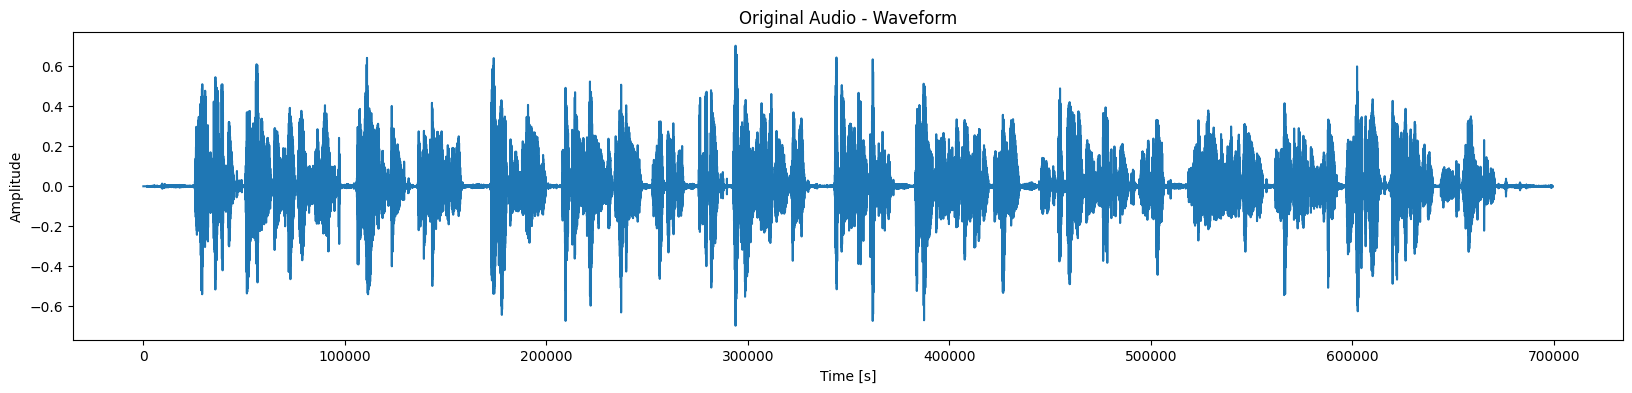

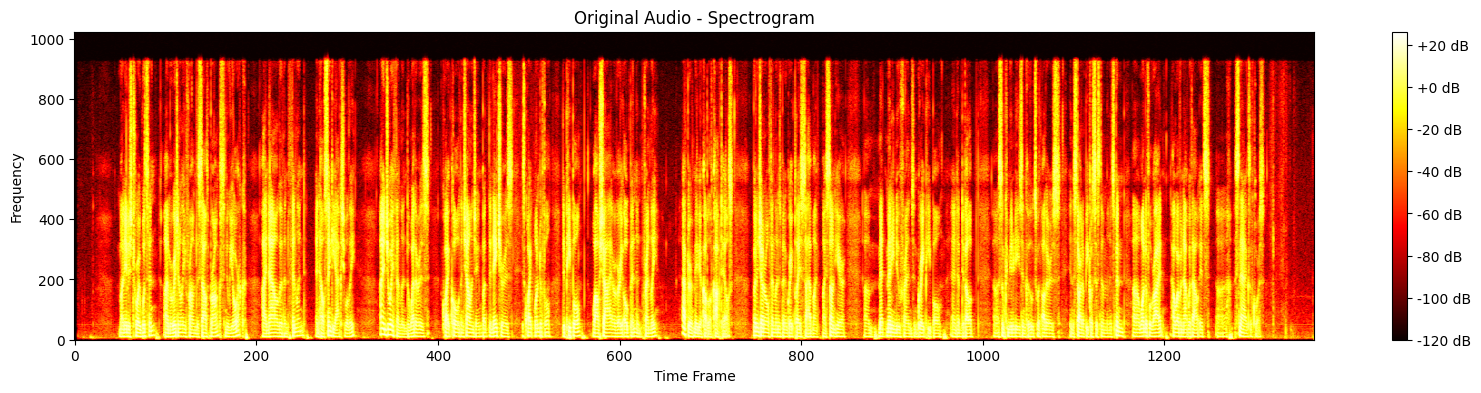

In [ ]:
plot_waveform_and_specgram(audio.squeeze(), sr, "Original Audio")
play_audio(audio, sr)


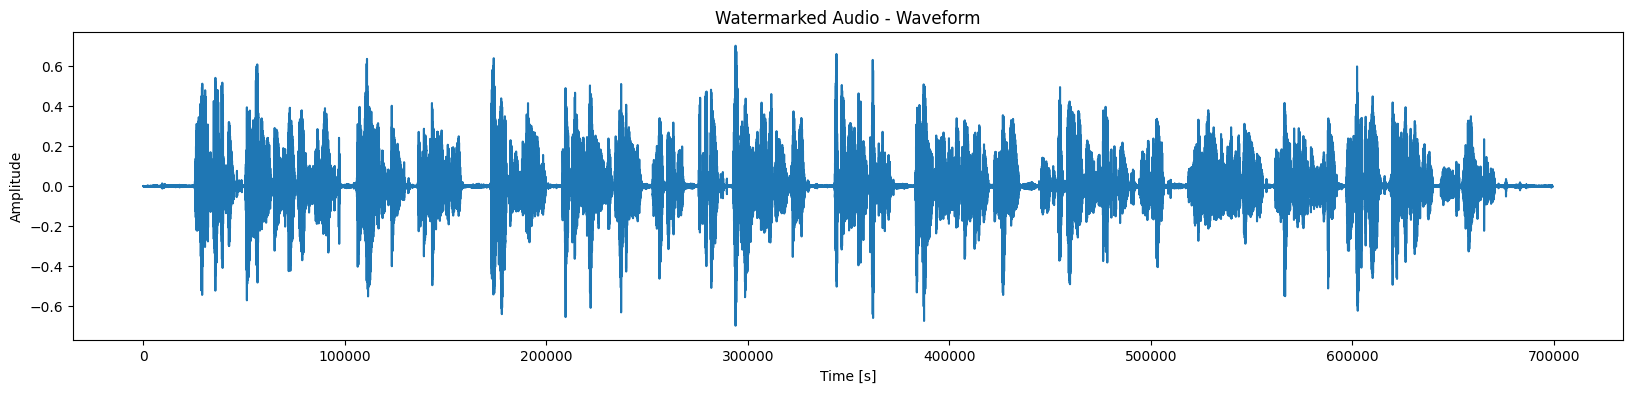

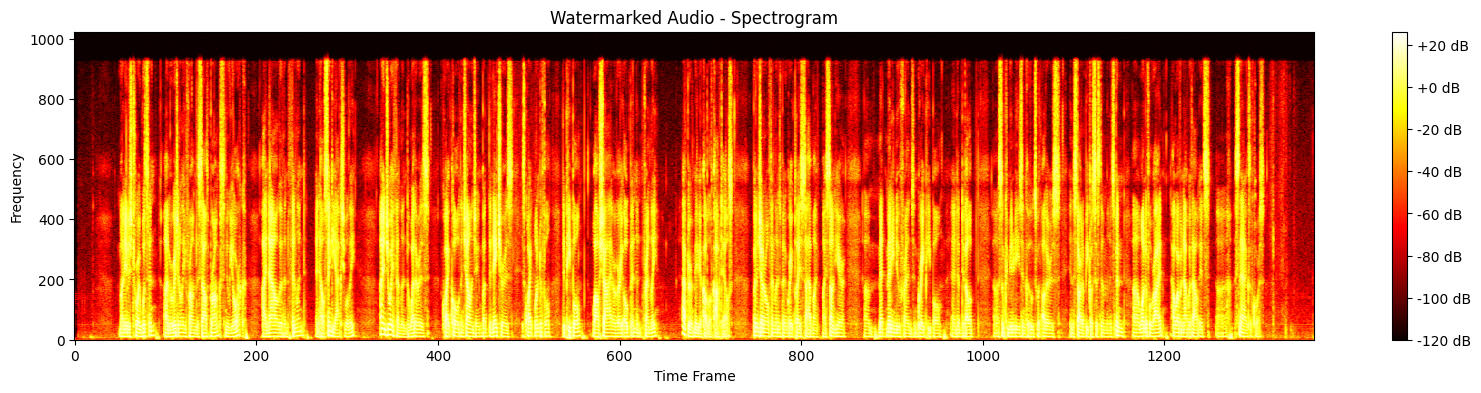

In [ ]:
from audioseal import AudioSeal

# Initialize the model and watermark the audio
model = AudioSeal.load_generator("audioseal_wm_16bits")
audios = audio.unsqueeze(0)  # Ensure audio has a batch dimension
watermarked_audio = model(audios, alpha=1)

# Visualize watermarked audio
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, "Watermarked Audio")
play_audio(watermarked_audio.squeeze(), sr)


In [ ]:
detector = AudioSeal.load_detector("audioseal_detector_16bits")
result, message = detector.detect_watermark(watermarked_audio, message_threshold=0.5)
print(f"This audio is likely {'watermarked' if result else 'not watermarked'} based on watermark detection.")


Downloading: "https://dl.fbaipublicfiles.com/audioseal/6edcf62f/detector.pth" to /root/.cache/audioseal/d377e551c354e9b70cb7ebd5
100%|██████████| 33.1M/33.1M [00:00<00:00, 306MB/s]


This audio is likely watermarked based on watermark detection.
